In [1]:
import requests
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
from collections import Counter
from goatools.obo_parser import GODag
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
#Libraries____________________-

In [2]:
#fetch sequences
def uniprotSQ(query,file):
        res=requests.get("https://rest.uniprot.org/uniprotkb/stream?query="+query)
        with open(file,"w")as store_file:
                store_file.write(res.text)
        return "Results stored"
uniprotSQ("reviewed:true+go:*+length:[121+TO+121]&format=tsv&fields=accession,sequence,go_id","protSQLeq121.tsv")

'Results stored'

In [2]:
#read and pre-process
df = pd.read_csv("protSQLeq121.tsv", sep="\t")
print(df.head(3))
print("nrows: ",df.shape[0])
print("ncol: ",df.shape[1])
#____________________

    Entry                                           Sequence  \
0  C0HLF0  NLFQFRKMIKKMTKKEPVVYYAFYGCYCGKGGRGKPKDATDRCCFV...   
1  I6L8L6  SLFQLGKMILQETGKNPAASYGAYGCNCGVLGRGKPKDATDRCCYV...   
2  O14352  MLPLTLLNATQGRPILVELKNGETFNGHLENCDNYMNLTLREVIRT...   

                                   Gene Ontology IDs  
0  GO:0005509; GO:0005543; GO:0005576; GO:0006644...  
1  GO:0005509; GO:0005543; GO:0005576; GO:0006644...  
2  GO:0000387; GO:0000932; GO:0000956; GO:0005634...  
nrows:  1321
ncol:  3


go.obo: fmt(1.2) rel(2025-06-01) 43,448 Terms


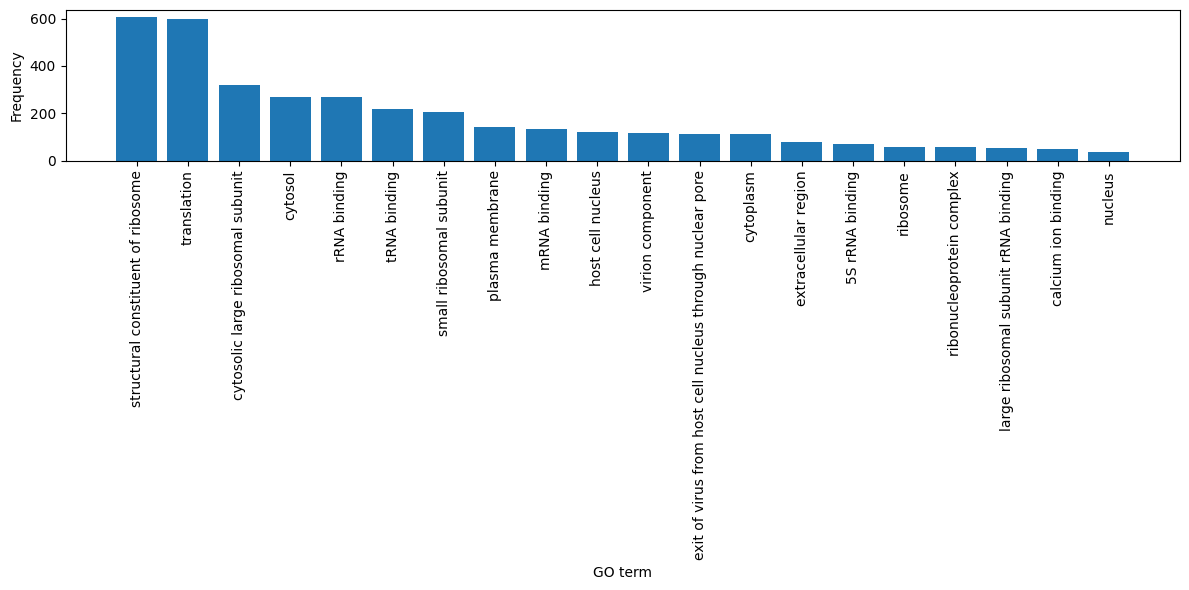

'Histogram created!'

In [13]:
#GO term histogram
go_dag = GODag("go.obo")
def go_hist(data_frame):
        go_terms=data_frame.iloc[:,-1] #last column is GO term
        go_terms=go_terms.str.split("; ")
        go_terms=list(chain.from_iterable(go_terms))
        go_terms=[go_dag[term].name for term in go_terms if term in go_dag]
        counts=Counter(go_terms)
        data=pd.DataFrame(counts.items(),columns=["GO","count"])
        data=data.sort_values(by="count",ascending=False)
        plt_data=data.head(20)
        plt.figure(figsize=(12,6))
        plt.bar(plt_data["GO"],plt_data["count"])
        plt.xticks(rotation=90)
        plt.xlabel("GO term")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
        return "Histogram created!"
go_hist(df)

In [3]:
df["Gene Ontology IDs"]=df["Gene Ontology IDs"].str.split('; ')

In [4]:
df["Gene Ontology IDs"].head(3)
#print(df[df["Gene Ontology IDs"].apply(lambda x: isinstance(x, float))]) #checking for floats

0    [GO:0005509, GO:0005543, GO:0005576, GO:000664...
1    [GO:0005509, GO:0005543, GO:0005576, GO:000664...
2    [GO:0000387, GO:0000932, GO:0000956, GO:000563...
Name: Gene Ontology IDs, dtype: object

In [5]:
df["Gene Ontology IDs"] = df["Gene Ontology IDs"].apply(
    lambda go_list: [go.strip() for go in go_list]
) #remove white space

In [6]:
#Encode GO terms__________________
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["Gene Ontology IDs"])
print(Y[:10])
df["multi-hit GO"]=[list(row) for row in Y]
print(df["multi-hit GO"].head(3))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: multi-hit GO, dtype: object


In [ ]:
#Trouble shooting Y, to check if it displays expected behavior
print(f"Shape of Y: {Y.shape}")
print(f"Total unique GO terms found: {len(mlb.classes_)}")
print(f"GO terms recognized: {mlb.classes_[:10]}")
# How many samples have 0 labels?
zero_rows = np.where(Y.sum(axis=1) == 0)[0]
print(f"Rows with 0 GO terms after binarization: {len(zero_rows)}")

In [39]:
#Encode protein sequences_________________
def one_hit(sequence):
        clmns=["A","L","K","W","F","Y","G","D","N","C","T","V","M","R","I","S","P","H","E","Q"]
        rows=[i for i in sequence]
        df = pd.DataFrame(index=rows, columns=clmns)
        for row in df.index:
                for clmn in df.columns:
                        if row==clmn:
                                df.loc[row,clmn]=1.0
                        else:
                                df.loc[row,clmn]=0.0
        return df.values.astype(np.float32)
#________________________________________________
sequences=list(df['Sequence'])
X_train = np.stack([one_hit(seq).astype(np.float32) for seq in df["Sequence"]]) #ML x-val
"""
matrices=[]
step=0
while step<df.shape[0]:
        matrices.append(one_hit(df.iloc[step,1]))
        step+=1
print(f"{step-1} sequences added!")
df["one_hit matrix"]=matrices
"""
#df.to_csv('mouse_prot_MLin.csv', sep='\t', index=False)
print(sequences[:3])

['NLFQFRKMIKKMTKKEPVVYYAFYGCYCGKGGRGKPKDATDRCCFVHDCCYEKVTGCNPKWGYYTYSMNKQIVCGGDDPCKKQVCECDKAAAICFRDNLKTYKKKYMSFPNFFCTDPSEKC', 'SLFQLGKMILQETGKNPAASYGAYGCNCGVLGRGKPKDATDRCCYVHKCCKKKLTGCDPKKDRYSYSWKDKTIVCGENNPCLKELCECDKAVAICLRENLNTYNKKYRYHLKPFCKKADPC', 'MLPLTLLNATQGRPILVELKNGETFNGHLENCDNYMNLTLREVIRTMPDGDKFFRLPECYIRGNNIKYLRIQDEVLSQVAKQQAQQRENRGSRFRGRGQRGRGNYGHTAPNRRGRGRGGHM']


In [42]:
X_train = X_train.reshape(X_train.shape[0], -1)  # (num_samples, 2420) flattens to 2D

In [13]:
mL_input=pd.read_csv('mouse_prot_MLin.csv', sep='\t')
mL_input.columns

Index(['Entry', 'Sequence', 'Gene Ontology IDs', 'multi-hit GO',
       'one_hit matrix'],
      dtype='object')

In [24]:
X_train,Y_train=mL_input["one_hit matrix"],df['multi-hit GO']
print(X_train[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [26]:
X_train = np.array(X_train.tolist())  # convert Series of arrays/lists into NumPy array
X_train = X_train.reshape(X_train.shape[0], -1)  # flatten X_train

In [28]:
Y_train = np.stack(Y_train.values).astype(np.float32)
print(Y_train[:3])
print(Y_train.shape[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1321


In [29]:
Y_train = np.array(Y_train.tolist()).astype(np.float32)
print(Y_train.shape)

(1321, 694)


In [40]:
print(X_train.dtype)
print(Y_train.dtype)

float32
float32


In [43]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(Y_train.shape[1], activation='sigmoid')  
]) #building model
#______________________________________

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Important for multilabel classification
    metrics=['accuracy']
) #compiling model

#____________________________________

model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2) #train model
#Finally BRUH

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0354 - loss: 0.5918 - val_accuracy: 0.0000e+00 - val_loss: 0.0407
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0461 - loss: 0.0389 - val_accuracy: 0.0340 - val_loss: 0.0188
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0776 - loss: 0.0294 - val_accuracy: 0.1358 - val_loss: 0.0182
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0627 - loss: 0.0264 - val_accuracy: 0.1396 - val_loss: 0.0166
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0928 - loss: 0.0235 - val_accuracy: 0.0642 - val_loss: 0.0154
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0743 - loss: 0.0215 - val_accuracy: 0.0906 - val_loss: 0.0144
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0890 - loss: 0.0199 - val_accuracy: 0.0943 - val_loss: 0.0135
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0962 - loss: 0.0176 - val_accuracy: 0.1245

In [48]:
# Predict on some data (e.g., first 5 samples)
#1. Pick your protein sequence
#2. Convert it to a one_hot matrix
#3. Flatten and reshape for compatiability
#4. Feed as an X_test
onehot = one_hit("HSWFPQRVPHDGDSVTVETGHLLLLDANTSFLNSLHIKGGKLIFMDPGPIELRAHSILITDGGELHIGSEEKPFQGKARIKIYGSVHSTPFFPYGVKFLAVRNGTLSLHGSVPEVTVTYLQ")

# Convert to float32 if not already
onehot = onehot.astype(np.float32)

# Flatten and add batch dimension: shape becomes (1, 2420)
X_test = onehot.reshape(1, -1)

# Predict
predictions = model.predict(X_test)

# Output predictions
print(predictions)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
[[1.17040481e-02 9.28736757e-03 1.06543666e-02 4.01975121e-03
  1.72801607e-03 6.46078959e-03 4.21366701e-03 2.18332503e-02
  1.28750491e-03 6.22299360e-03 1.21045085e-02 1.91527477e-03
  4.05954488e-05 1.26983074e-03 8.21674708e-03 1.95562057e-02
  1.07628840e-03 3.17153404e-03 1.51477347e-03 1.95113046e-03
  2.01929454e-03 1.20636856e-03 1.72023550e-02 2.92394194e-03
  6.30174484e-03 5.43891406e-03 1.96395651e-03 1.41853432e-03
  3.46934004e-03 1.88584451e-03 3.16974940e-03 4.95229103e-03
  1.69593620e-03 1.30455464e-03 4.03876975e-03 1.40279101e-03
  1.45683635e-03 2.01290846e-03 1.38410731e-04 9.87709034e-04
  1.60613784e-03 2.51304135e-02 5.76502783e-03 1.59406615e-03
  1.80513633e-03 1.33753289e-03 2.51572463e-03 1.59185624e-03
  1.31972728e-03 1.47842104e-03 2.64252000e-03 1.30128497e-02
  1.57929468e-03 8.96429829e-03 1.41223019e-03 1.21329958e-03
  1.09284814e-03 1.47245184e-03 7.32579753e-02 3.39498697e-03
  2.15656077e-03 1.55071181e-03

In [52]:
threshold = 0.01
binary_predictions = (predictions > threshold).astype(int)
print(binary_predictions)

[[1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
  1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
  1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0
  0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 

In [59]:
predicted_go_term = mlb.inverse_transform(binary_predictions)
predicted_go_term = list(predicted_go_term[0])
print(predicted_go_term)

['GO:0000027', 'GO:0000049', 'GO:0000105', 'GO:0000160', 'GO:0000287', 'GO:0000421', 'GO:0001682', 'GO:0002181', 'GO:0003677', 'GO:0003700', 'GO:0003723', 'GO:0003735', 'GO:0004526', 'GO:0004636', 'GO:0004803', 'GO:0005179', 'GO:0005506', 'GO:0005509', 'GO:0005524', 'GO:0005543', 'GO:0005576', 'GO:0005615', 'GO:0005634', 'GO:0005654', 'GO:0005737', 'GO:0005762', 'GO:0005829', 'GO:0005840', 'GO:0005886', 'GO:0006260', 'GO:0006313', 'GO:0006412', 'GO:0006457', 'GO:0006633', 'GO:0006644', 'GO:0006914', 'GO:0007218', 'GO:0008033', 'GO:0008097', 'GO:0008137', 'GO:0008270', 'GO:0008897', 'GO:0009399', 'GO:0009507', 'GO:0015031', 'GO:0015934', 'GO:0016020', 'GO:0016042', 'GO:0016226', 'GO:0016853', 'GO:0019843', 'GO:0020037', 'GO:0022625', 'GO:0022627', 'GO:0030490', 'GO:0030677', 'GO:0030964', 'GO:0031410', 'GO:0031640', 'GO:0032153', 'GO:0039675', 'GO:0042025', 'GO:0042130', 'GO:0042597', 'GO:0042742', 'GO:0042781', 'GO:0043024', 'GO:0043093', 'GO:0044423', 'GO:0044781', 'GO:0045892', 'GO:0

In [62]:
go_dag = GODag("go.obo")
go_terms_found=[go_dag[term].name for term in predicted_go_term]
for term in go_terms_found:
    print(term)


go.obo: fmt(1.2) rel(2025-06-01) 43,448 Terms
ribosomal large subunit assembly
tRNA binding
L-histidine biosynthetic process
phosphorelay signal transduction system
magnesium ion binding
autophagosome membrane
tRNA 5'-leader removal
cytoplasmic translation
DNA binding
DNA-binding transcription factor activity
RNA binding
structural constituent of ribosome
ribonuclease P activity
phosphoribosyl-ATP diphosphatase activity
transposase activity
hormone activity
iron ion binding
calcium ion binding
ATP binding
phospholipid binding
extracellular region
extracellular space
nucleus
nucleoplasm
cytoplasm
mitochondrial large ribosomal subunit
cytosol
ribosome
plasma membrane
DNA replication
DNA transposition
translation
protein folding
fatty acid biosynthetic process
phospholipid metabolic process
autophagy
neuropeptide signaling pathway
tRNA processing
5S rRNA binding
NADH dehydrogenase (ubiquinone) activity
zinc ion binding
holo-[acyl-carrier-protein] synthase activity
nitrogen fixation
chloro

In [63]:
probabilities = model.predict(X_test)
avg_confidence = np.mean(probabilities, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


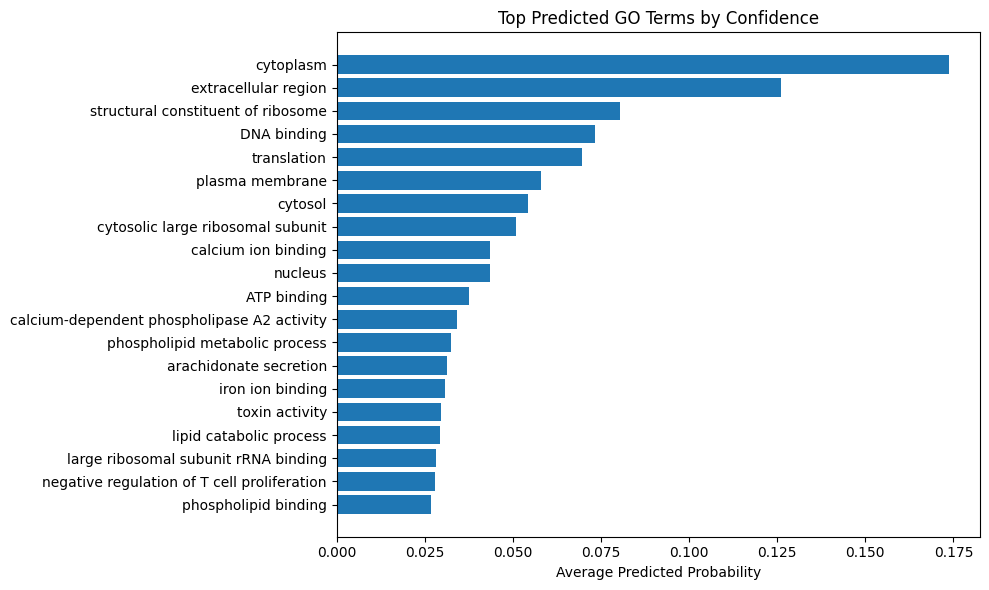

In [70]:
top_n = 20
top_indices = np.argsort(avg_confidence)[-top_n:]
top_terms = [mlb.classes_[i] for i in top_indices]
top_terms=[go_dag[term].name for term in top_terms]
top_scores = avg_confidence[top_indices]

# plot
plt.figure(figsize=(10, 6))
plt.barh(top_terms, top_scores)
plt.xlabel('Average Predicted Probability')
plt.title('Top Predicted GO Terms by Confidence')
plt.tight_layout()
plt.show()